<a href="https://colab.research.google.com/github/Chameee/dl-pj2/blob/master/dl_pj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

## Load CIFAR-10 Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(
#     [transforms.ToTensor()])


batch_size = 4

######################################################################
# 1. Prepare CIFAR-10 training and testing data.
######################################################################

train_dataset = CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)

test_dataset = CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
len(train_dataloader)
len(test_dataloader)

2500

In [4]:
next(iter(train_dataloader))[0][0].size()

torch.Size([3, 32, 32])

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np

In [7]:
len(train_dataset.targets)

50000

In [8]:
data, label = train_dataset[0]

## Visualize some training examples

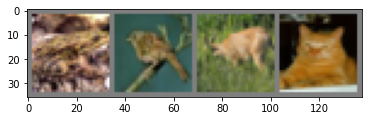

 frog  bird  deer   cat


In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


## Get device for training

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Define the Class of neural network


In [11]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pooling = nn.MaxPool2d(5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
)
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(16384), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10),
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.pooling(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.flatten(out)
        out = self.linear_relu_stack(out)
        return out

## Define training process

In [12]:
learning_rate = 0.001
batch_size = 4
epochs = 5


In [13]:
model = SimpleNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.adam(model.parameters(), learning_rate)


In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device)).to(device)
        loss = loss_fn(pred, y.to(device)).to(device)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device)).to(device)
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [15]:
model.load_state_dict(torch.load(f'./model_withoutbn_epo20'))

FileNotFoundError: ignored

In [16]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.460995  [    0/50000]
loss: 1.638975  [ 4000/50000]
loss: 0.984798  [ 8000/50000]
loss: 1.663149  [12000/50000]
loss: 1.806958  [16000/50000]
loss: 1.044124  [20000/50000]
loss: 1.649587  [24000/50000]
loss: 1.757357  [28000/50000]
loss: 1.701996  [32000/50000]
loss: 1.505188  [36000/50000]
loss: 1.717715  [40000/50000]
loss: 1.183126  [44000/50000]
loss: 0.759240  [48000/50000]
Test Error: 
 Accuracy: 54.7%, Avg loss: 0.324607 

Epoch 2
-------------------------------
loss: 0.975972  [    0/50000]
loss: 1.442956  [ 4000/50000]
loss: 1.055853  [ 8000/50000]
loss: 0.813128  [12000/50000]
loss: 1.151667  [16000/50000]
loss: 1.847835  [20000/50000]
loss: 1.098771  [24000/50000]
loss: 0.838584  [28000/50000]
loss: 0.916660  [32000/50000]
loss: 1.100603  [36000/50000]
loss: 1.767433  [40000/50000]
loss: 0.278031  [44000/50000]
loss: 1.558182  [48000/50000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 0.283503 

Epoch 3
-------------------------------
loss: 1.467650  [    0/50000]
loss: 

In [17]:
torch.save(model, "./model_epoch20.pth")

In [20]:
model = SimpleNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.361213  [    0/50000]
loss: 2.274453  [ 4000/50000]
loss: 2.306742  [ 8000/50000]
loss: 2.319102  [12000/50000]
loss: 2.349589  [16000/50000]
loss: 2.324081  [20000/50000]
loss: 2.291013  [24000/50000]
loss: 2.354437  [28000/50000]
loss: 2.380514  [32000/50000]
loss: 2.271056  [36000/50000]
loss: 2.388054  [40000/50000]
loss: 2.313551  [44000/50000]
loss: 2.270240  [48000/50000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.576504 

Epoch 2
-------------------------------
loss: 2.320681  [    0/50000]
loss: 2.266017  [ 4000/50000]
loss: 2.315230  [ 8000/50000]
loss: 2.293490  [12000/50000]
loss: 2.313237  [16000/50000]
loss: 2.291718  [20000/50000]
loss: 2.284229  [24000/50000]
loss: 2.320760  [28000/50000]
loss: 2.414521  [32000/50000]
loss: 2.327467  [36000/50000]
loss: 2.292341  [40000/50000]
loss: 2.290012  [44000/50000]
loss: 2.323450  [48000/50000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.576196 

Epoch 3
----------------------------

KeyboardInterrupt: ignored